In [1]:
# Imports
from os import makedirs
from os.path import join
import joblib
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

from utils import get_model_checkpoint_filepaths, pairwise_cosine_distances
from analysis_utils import (k_medoids_cluster_hyperparameter_search, plot_cluster_metric_scores,
                            words_in_clusters, plot_cluster_sizes, inspect_word_clusters)
from word_embeddings.eval_utils import plot_word_vectors
from word_embeddings.word2vec import load_model_training_output

# Prepare data

In [2]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir="../output/word2vec_training/word2vec_enwiki_sept_2020_word2phrase",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights = w2v_training_output["last_embedding_weights"]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]

In [3]:
# Restrict vocabulary size for analysis
vocab_size = 10000

In [4]:
# Precompute cosine distance matrix
word_embeddings_to_precompute = last_embedding_weights[:vocab_size]
word_embeddings_distances = pairwise_cosine_distances(word_embeddings_to_precompute)

# Clustering

In [5]:
ks = [
    2, 3, 4, 5, 10, 50,
    100, 150, 200, 300, 400, 500, 750,
    1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000
]
k_medoids_param_grid = ParameterGrid({
    "n_clusters": ks,
})
k_medoids_default_params = {
    "random_state": rng_seed,
    "metric": "cosine"
}
should_do_hyperparameter_search = False
if should_do_hyperparameter_search:
    pred_cluster_labels = k_medoids_cluster_hyperparameter_search(
        param_grid=k_medoids_param_grid,
        default_params=k_medoids_default_params,
        word_embeddings=word_embeddings_to_precompute,
        word_embeddings_pairwise_dists=word_embeddings_distances,
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki",
        output_filepath_suffix="k_medoids_labels",
    )
else:
    pred_cluster_labels = joblib.load(
        "../output/word2vec_cluster_analysis/word2vec-enwiki-k_medoids_labels.joblib"
    )

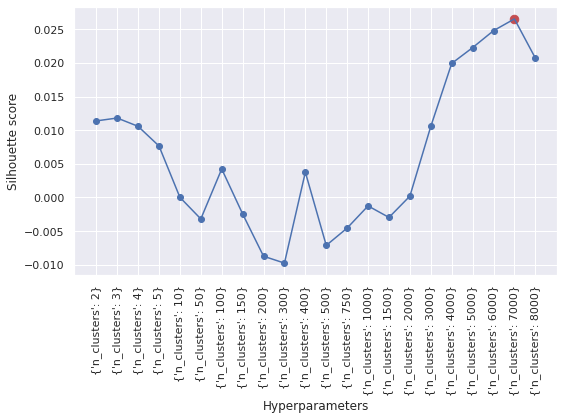

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_cluster_metric_scores(
    metric_scores=pred_cluster_labels["metric_scores"],
    hyperparameters=[{"n_clusters": k} for k in ks],
    best_score_idx=pred_cluster_labels["best_cluster_labels_idx"],
    metric_name="Silhouette",
    ax=ax
)